In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn import decomposition
from matplotlib.backends.backend_pdf import PdfPages
import importlib
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering
import seaborn as sns
import umap

sys.path.append('..')
import catrace
from catrace import dataio
import catrace.process_time_trace as ptt
import catrace.plot_trace as pltr
import catrace.pattern_correlation as pcr
import catrace.exp_collection as ecl
import catrace.cluster as catclust
from catrace.frame_time import convert_sec_to_frame
from catrace.trace_dataframe import concatenate_planes
importlib.reload(catrace.plot_trace)
importlib.reload(ecl)
importlib.reload(pltr)
import catrace.frame_time as frame_time
import dataset_param as dtpar

In [2]:
exp_list = [( '2021-02-05-DpOBEM-JH9','phe-arg'),
            ('2021-03-18-DpOBEM-JH10','phe-arg'),
            ('2021-03-19-DpOBEM-JH10','phe-arg'),
            ('2021-04-02-DpOBEM-JH11','phe-arg'),
            ('2021-04-03-DpOBEM-JH11','phe-arg'),
            ('2021-05-01-DpOBEM-JH13','phe-arg'),
            ('2021-05-22-DpOBEM-JH14','phe-arg'),
            ('2021-07-15-DpOBEM-N2'  ,'naive'),
            ('2021-07-16-DpOBEM-N3' ,'naive'),
            ('2021-07-30-DpOBEM-JH17','arg-phe'),
            ('2021-07-31-DpOBEM-JH17','arg-phe'),
            ('2021-09-02-DpOBEM-JH18','arg-phe'),
            ('2021-09-03-DpOBEM-JH18','arg-phe'),
            ('2021-09-04-DpOBEM-JH18','arg-phe'),
            ('2021-09-15-DpOBEM-JH20','phe-arg'),
            ('2021-09-17-DpOBEM-JH20','phe-arg'),
            ('2021-09-18-DpOBEM-JH20','phe-arg'),
            ('2021-09-29-DpOBEM-JH21','arg-phe'),
            ('2021-10-01-DpOBEM-JH21','arg-phe'),
            ('2021-10-02-DpOBEM-JH21','arg-phe'),
            ('2021-11-10-DpOBEM-JH23','phe-trp'),
            ('2021-11-14-DpOBEM-JH23','phe-trp'),
            ('2021-11-24-DpOBEM-JH24','phe-trp'),
            ('2021-11-27-DpOBEM-JH24','phe-trp'),
            ('2021-11-26-DpOBEM-JH24','phe-trp'),
            ('2021-12-10-DpOBEM-N4','naive'),
            ('2021-12-31-DpOBEM-N7','naive'),
            ('2022-01-23-DpOBEM-N8','naive'),
            ('2022-01-30-DpOBEM-N9','naive'),
            ('2022-02-13-DpOBEM-N10','naive'),
            ('2022-02-20-DpOBEM-N11','naive')]


region_list = ['Dp', 'OB']
frame_rate = 30/4
#num_trial = 3
exp_info = dict(num_trial=3)
# TODO odor list bile acid order might be wrong!!
odor_list = ['phe', 'trp', 'arg', 'tdca', 'tca', 'gca', 'acsf', 'spont']
#plane_nb_list = np.array([1,2,3,4]) - 1
data_root_dir = '/media/hubo/WD_BoHu/BCE/Ca_imaging/results/'
dfovf_dict = dict()
load_data = False
if load_data:
    for region in region_list:
        dfovf_dict[region] = dict()
        for exp in exp_list:
            exp_name = exp[0]
            print(exp_name, region)
            dfovf_dict[region][exp_name] = ecl.load_dfovf(data_root_dir, exp_name, region)

Plot averaged time course for each odor (used to determine the time window for computing tuning curve)

In [3]:
region = 'Dp'
all_response = pd.read_pickle('../../../results/JH_analysis/all_response_select_{}.pkl'.format(region))
import catrace.scale as catscale
from sklearn.cluster import KMeans, AgglomerativeClustering
H = catscale.standard_scale(all_response)
data = H.transpose()
fish_id = data.index.get_level_values('fish_id')
training_dict = dict(dtpar.exp_list)
train_cond= fish_id.map(training_dict)
cond_list = ['phe-arg', 'arg-phe', 'phe-trp', 'naive']
cond_order = {k: v for v, k in enumerate(cond_list)}
cond_order
cond_idx = train_cond.map(cond_order)


/home/hubo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [4]:
clusterable_embedding = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=8,
    random_state=42,
).fit_transform(data)

In [5]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(data)

In [6]:
standard_fit = umap.UMAP(random_state=42).fit(data)

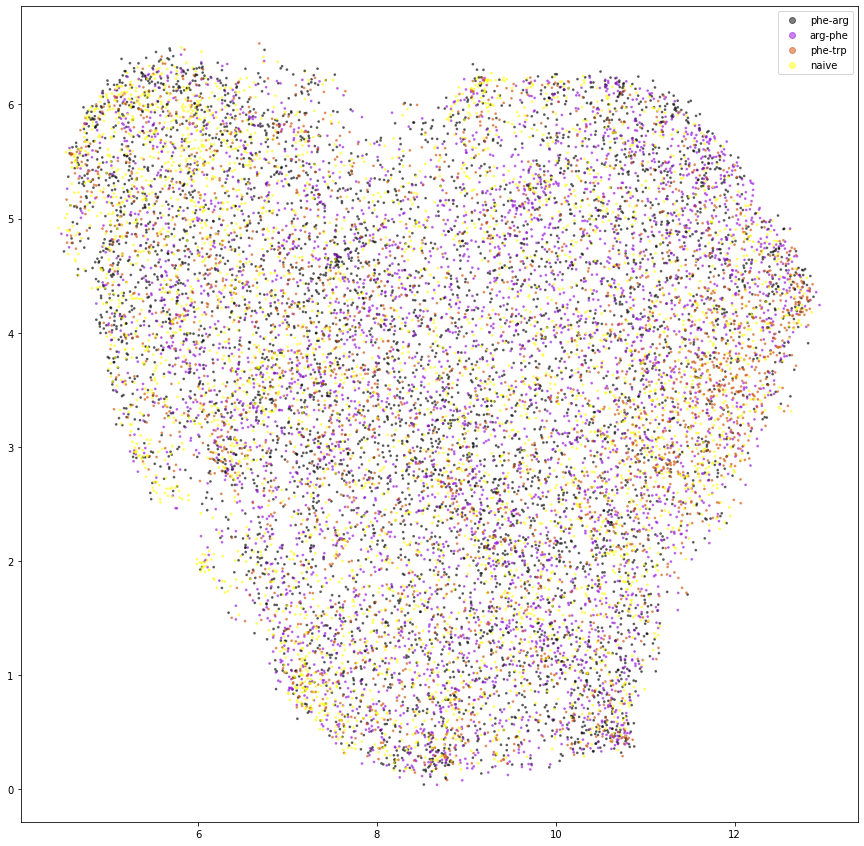

In [7]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(standard_embedding[:,0], standard_embedding[:,1], s=3, c=cond_idx, alpha=0.5, cmap='gnuplot')
ax.legend(handles=scatter.legend_elements()[0], labels=cond_list)

In [8]:
def plot_label_on_umap(labels, cmap='Spectral'):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    clustered = (labels >= 0)
    plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.2,
            alpha=0.5)
    scatter = plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.5,
            cmap=cmap)
    plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1])
    return fig


In [9]:
import phenograph
import importlib
importlib.reload(phenograph)
communities, graph, Q = phenograph.cluster(clusterable_embedding, k=50)

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.250291109085083 seconds
Jaccard graph constructed in 2.4432590007781982 seconds
Wrote graph to binary file in 0.3555881977081299 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.858458
After 6 runs, maximum modularity is Q = 0.86016
Louvain completed 26 runs in 10.638749599456787 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 13.932402610778809 seconds


In [37]:
np.unique(communities)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

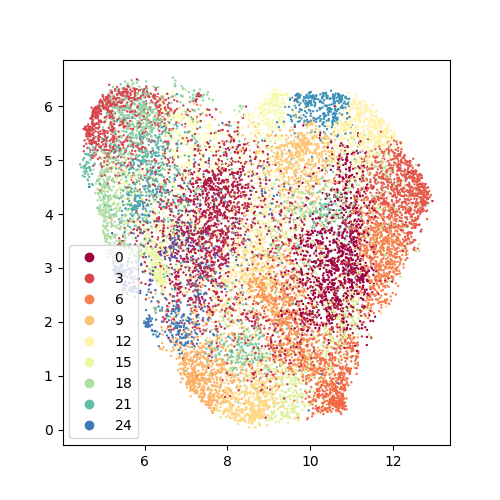

In [10]:
%matplotlib widget
importlib.reload(catclust)
cmap = catclust.get_cluster_cmap(communities, cmap='Spectral')
fig = plot_label_on_umap(communities, cmap=cmap)
fig.set_size_inches((5,5))

In [11]:
import umap.plot
umap.plot.output_notebook()

Loading BokehJS ...

In [12]:
hover_data = pd.DataFrame({'label': communities})
pp = umap.plot.interactive(standard_fit, labels=communities, hover_data=hover_data, point_size=2)
umap.plot.show(pp)

In [13]:
importlib.reload(catclust)
clustdf = catclust.get_cluster_df(H, communities)
cluster_mean_df = clustdf.groupby('cluster_id').mean()
cluster_mean_df = pd.melt(cluster_mean_df, var_name='trial_key', value_name='response', ignore_index=False).reset_index()

trial_list = list(cluster_mean_df.trial_key.unique())
trial_ord = cluster_mean_df.trial_key.map(lambda x: trial_list.index(x))
cluster_mean_df["trial"] = trial_ord
cluster_mean_df
cluster_mean_df = cluster_mean_df[cluster_mean_df.trial<18]
cluster_mean_df

,cluster_id,trial_key,response,trial
0,0.0,"(phe, 0)",0.567478,0
1,1.0,"(phe, 0)",0.024278,0
2,2.0,"(phe, 0)",0.579040,0
3,3.0,"(phe, 0)",-0.273767,0
4,4.0,"(phe, 0)",0.277930,0
...,...,...,...,...
481,22.0,"(gca, 2)",-0.098900,17
482,23.0,"(gca, 2)",-0.203784,17
483,24.0,"(gca, 2)",-0.252269,17
484,25.0,"(gca, 2)",2.338574,17


In [14]:
def _get_odor_list(trial_list):
    odor_list = [key[0] for key in trial_list]
    odor_list = list(dict.fromkeys(odor_list))
    return odor_list

In [15]:
def plot_cluster_tuning(cluster_mean_df, cmap="tab20c"):
    # Initialize the FacetGrid object
    pal = sns.color_palette(cmap) #sns.cubehelix_palette(n_clusters, rot=-.25, light=.7)
    g = sns.FacetGrid(cluster_mean_df, row="cluster_id", hue="cluster_id", aspect=15, height=.5, palette=pal)
    # Draw the densities in a few steps
    g.map(sns.barplot, "trial", 'response')
    # passing color=None to refline() uses the hue mapping
    #g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-.05, .2, int(float(label)), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "trial")
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.05)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    n_trials = cluster_mean_df.trial.max()
    trial_per_odor = 3
    trial_list2 = list(cluster_mean_df.trial_key.unique())
    for ax in g.axes.flat:
        ax.set_xticks(np.arange(0, n_trials, trial_per_odor)) # <--- set the ticks first
        ax.set_xticklabels(_get_odor_list(trial_list2))
        # ax.set_xlabel('Trial')
        ax.set(xlabel=None)

/home/hubo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


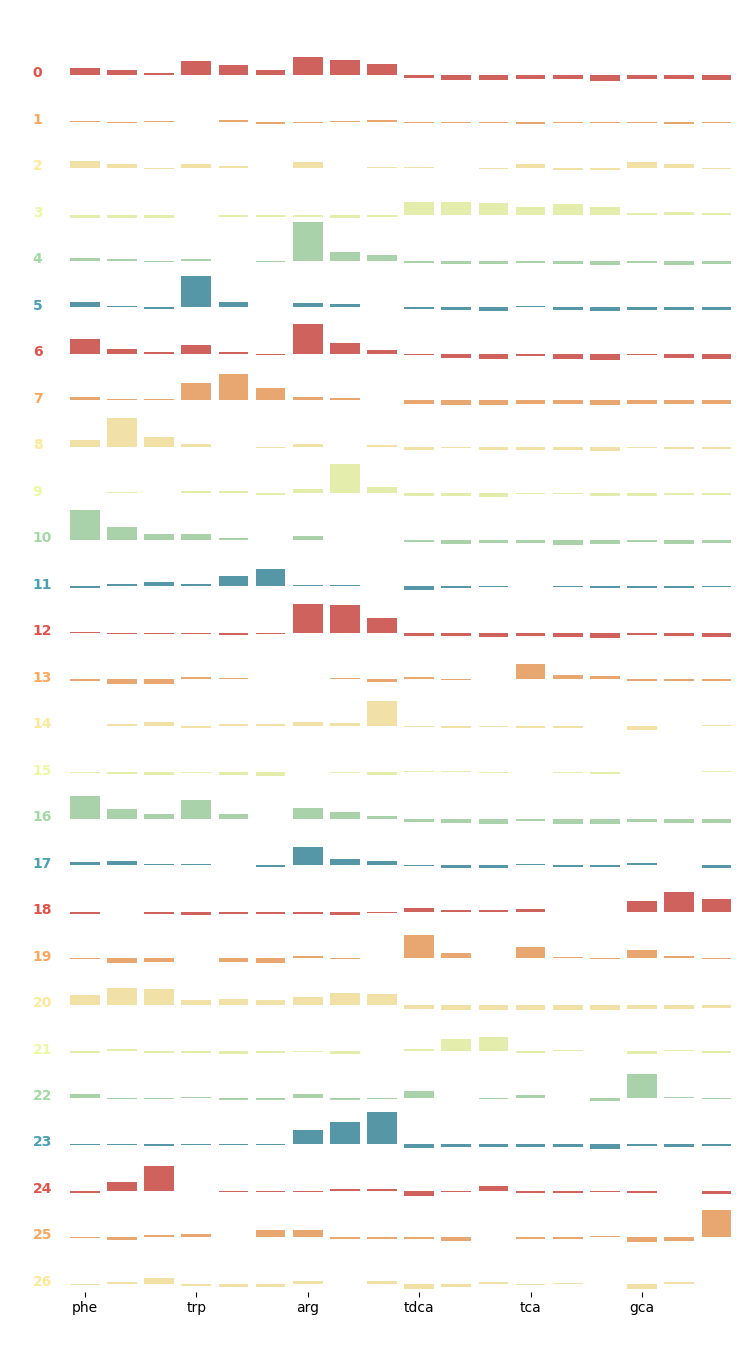

In [16]:
plot_cluster_tuning(cluster_mean_df, cmap="Spectral")

In [17]:
def plot_cluster_cont_with_stat(pairs):
    hue_plot_params = dict(x="cluster_id", y="ratio", hue="train_cond", hue_order=dtpar.cond_list,
                           data=cluster_count_df, palette="Set3")

    with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
        fig, ax = plt.subplots(figsize=(16,10))

    # Plot with seaborn
        ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
        annotator = Annotator(ax, pairs, **hue_plot_params)
        annotator.configure(test="t-test_ind").apply_and_annotate()

    # Label and show
        legend = ax.legend()
        frame = legend.get_frame()
        frame.set_facecolor('white')
        ax.set_ylabel('#neurons in cluster/total #neurons')
    return annotator

def get_significant_pairs(annotator):
    new_pairs = [[ano.data.group1, ano.data.group2] for ano in annotator.annotations if ano.data.pvalue < 0.05]
    return new_pairs

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

5_arg-phe vs. 5_phe-trp: t-test independent samples, P_val:3.663e-01 t=9.423e-01
6_arg-phe vs. 6_phe-trp: t-test independent samples, P_val:6.602e-02 t=-2.041e+00
7_arg-phe vs. 7_phe-trp: t-test independent samples, P_val:2.304e-01 t=1.270e+00
8_arg-phe vs. 8_phe-trp: t-test independent samples, P_val:7.340e-01 t=-3.485e-01
9_arg-phe vs. 9_phe-trp: t-test independent samples, P_val:1.409e-01 t=1.587e+00
10_arg-phe vs. 10_phe-trp: t-test independent samples, P_val:9.696e-01 t=3.897e-02
11_arg-phe vs. 11_phe-trp: t-test independent samples, P_val:5.518e-01 t=-6.139e-01
12_arg-phe vs. 12_phe-trp: t-test independent samples, P_val:2.352e-01 t=1.263e+00
13_arg-phe vs. 13_phe-trp: t-test independent samples, P_val:4.214e-01 t=-8.351e-01
14_arg-phe vs. 14_phe-trp: t-test independent samples, P_val:9.928e-01 t=9.279

10_phe-arg vs. 10_arg-phe: t-test independent samples, P_val:2.448e-01 t=-1.207e+00
10_phe-trp vs. 10_naive: t-test independent samples, P_val:6.584e-01 t=4.544e-01
11_phe-arg vs. 11_arg-phe: t-test independent samples, P_val:1.374e-01 t=1.564e+00
11_phe-trp vs. 11_naive: t-test independent samples, P_val:5.099e-01 t=6.810e-01
12_phe-arg vs. 12_arg-phe: t-test independent samples, P_val:7.196e-01 t=-3.653e-01
12_phe-trp vs. 12_naive: t-test independent samples, P_val:7.497e-01 t=-3.290e-01
13_phe-arg vs. 13_arg-phe: t-test independent samples, P_val:1.933e-01 t=1.358e+00
13_phe-trp vs. 13_naive: t-test independent samples, P_val:6.844e-01 t=4.175e-01
14_phe-arg vs. 14_arg-phe: t-test independent samples, P_val:8.849e-01 t=1.471e-01
14_phe-trp vs. 14_naive: t-test independent samples, P_val:5.312e-01 t=-6.464e-01
15_phe-arg vs. 15_arg-phe: t-test independent samples, P_val:5.259e-01 t=-6.485e-01
15_phe-trp vs. 15_naive: t-test independent samples, P_val:6.955e-01 t=-4.018e-01
16_phe-arg

19_phe-arg vs. 19_phe-trp: t-test independent samples, P_val:6.017e-01 t=-5.349e-01
19_arg-phe vs. 19_naive: t-test independent samples, P_val:4.172e-02 t=-2.241e+00
20_phe-arg vs. 20_phe-trp: t-test independent samples, P_val:4.144e-01 t=8.455e-01
20_arg-phe vs. 20_naive: t-test independent samples, P_val:8.743e-01 t=-1.611e-01
21_phe-arg vs. 21_phe-trp: t-test independent samples, P_val:6.678e-01 t=4.391e-01
21_arg-phe vs. 21_naive: t-test independent samples, P_val:5.274e-01 t=-6.481e-01
22_phe-arg vs. 22_phe-trp: t-test independent samples, P_val:3.167e-01 t=-1.041e+00
22_arg-phe vs. 22_naive: t-test independent samples, P_val:2.416e-01 t=-1.223e+00
23_phe-arg vs. 23_phe-trp: t-test independent samples, P_val:1.033e-01 t=1.752e+00
23_arg-phe vs. 23_naive: t-test independent samples, P_val:9.869e-01 t=1.677e-02
24_phe-arg vs. 24_phe-trp: t-test independent samples, P_val:1.641e-01 t=1.482e+00
24_arg-phe vs. 24_naive: t-test independent samples, P_val:8.602e-01 t=1.794e-01
25_phe-arg

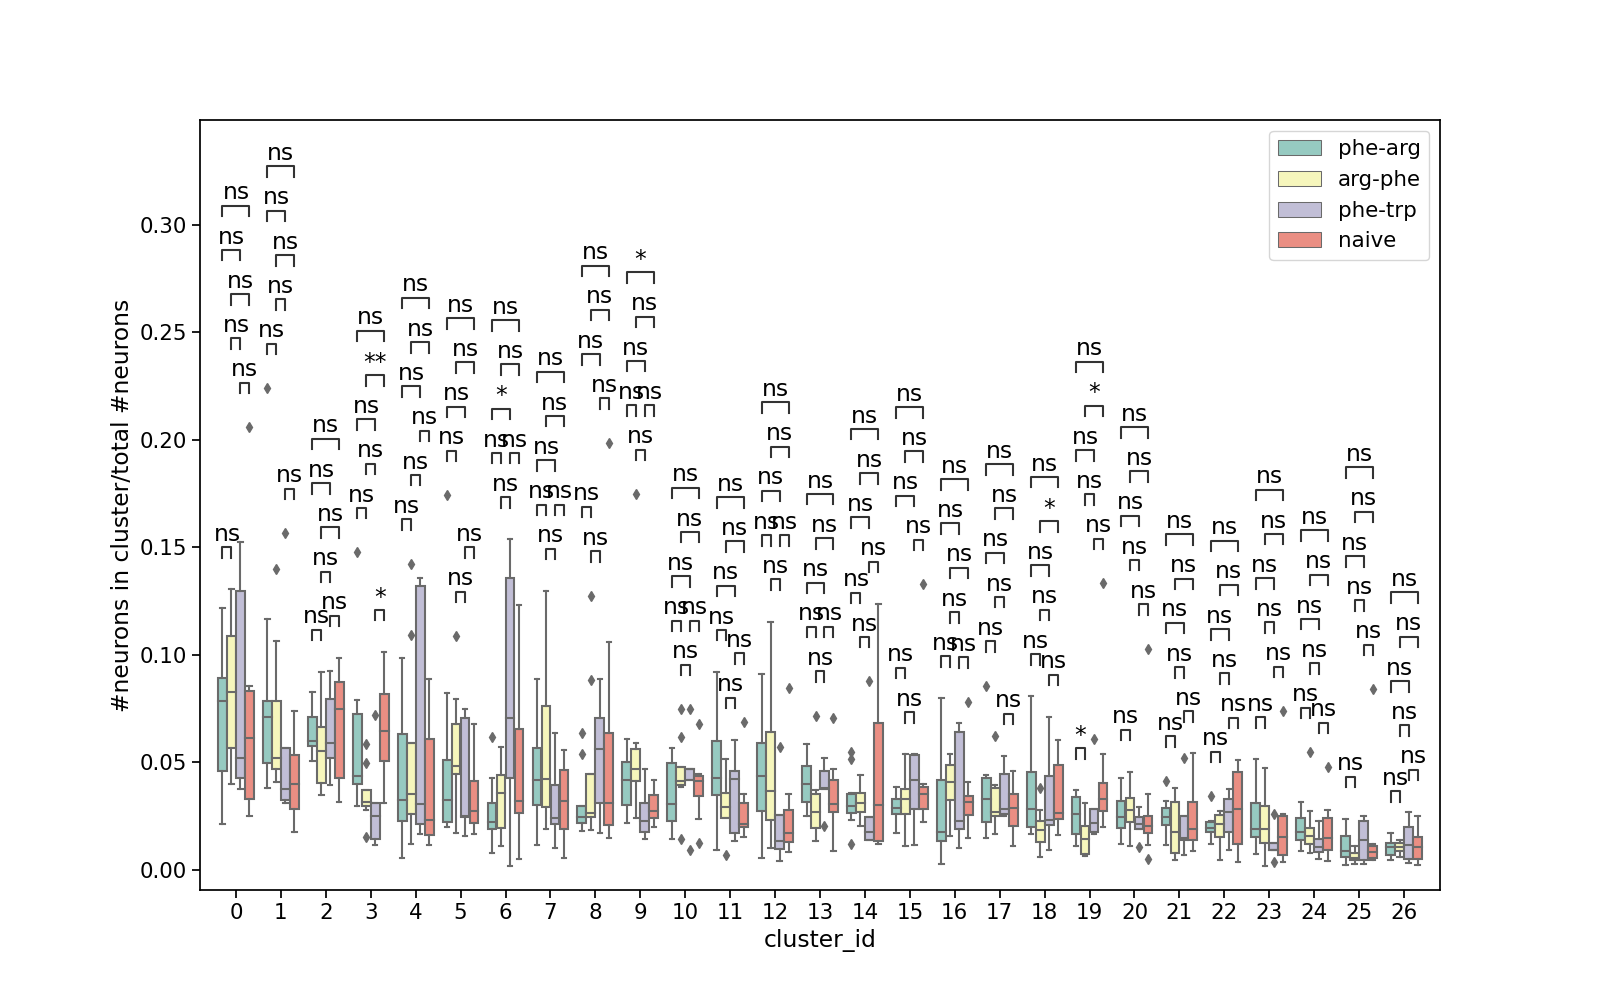

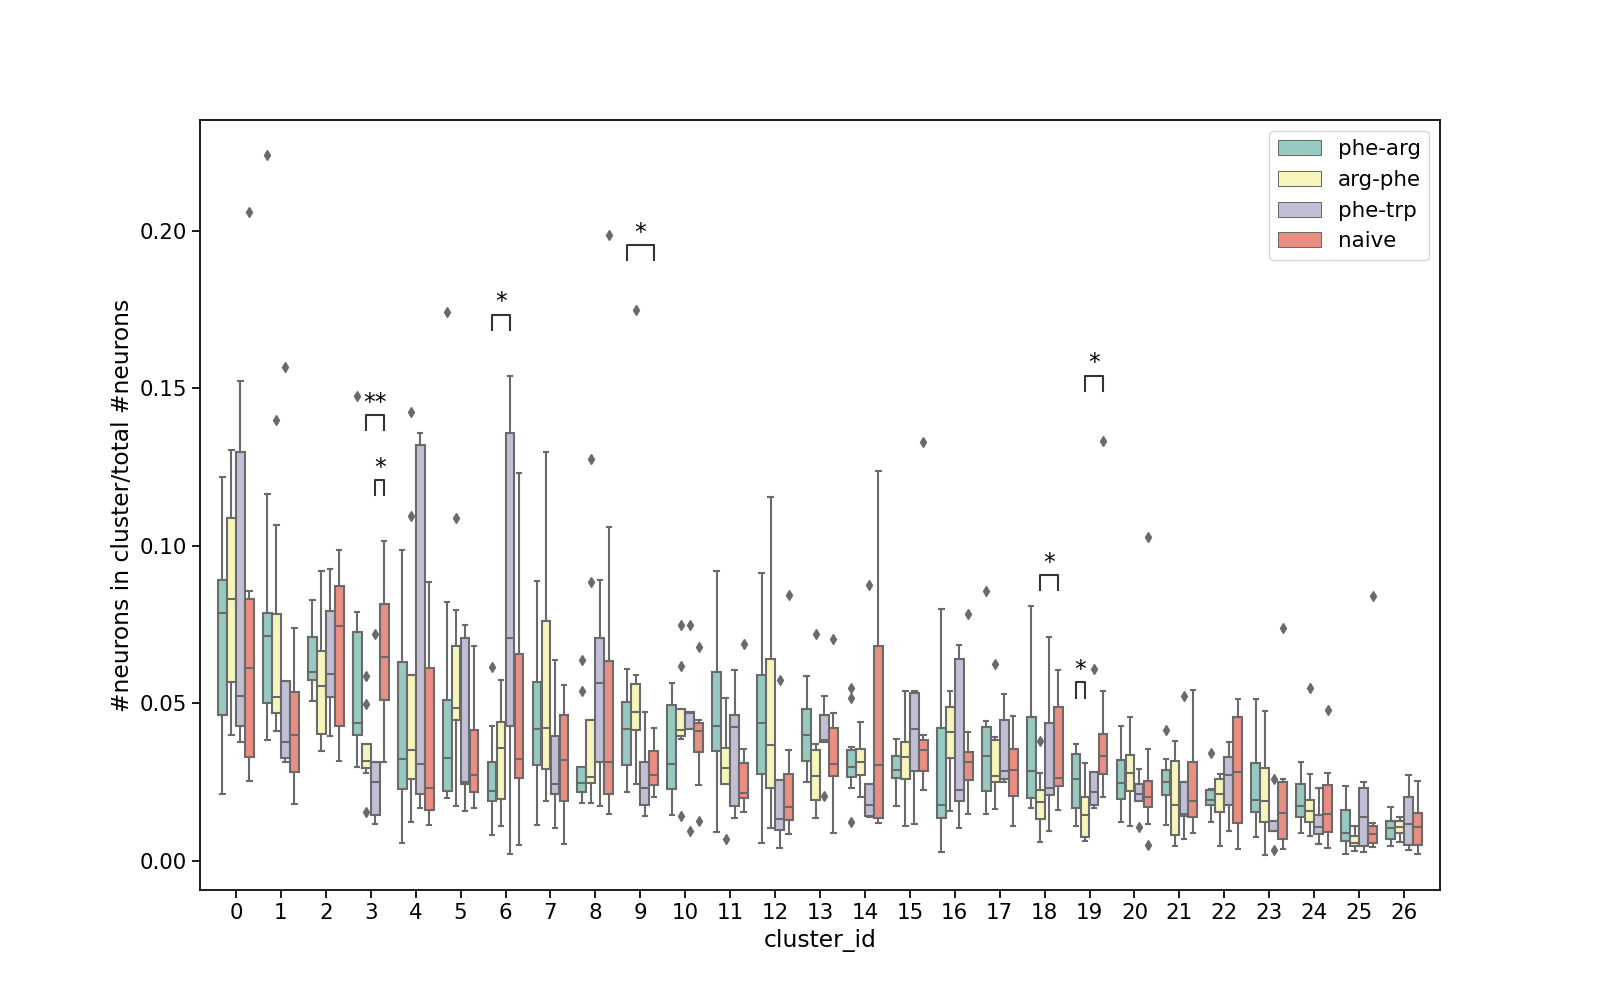

In [18]:
from statannotations.Annotator import Annotator
labels = communities
n_clusters = len(np.unique(labels))
cluster_df = pd.DataFrame(labels.reshape(1,-1), columns=all_response.columns)
cluster_df = cluster_df.transpose().rename(columns={0:'cluster_id'}).reset_index()
training_dict = dict(dtpar.exp_list)
cluster_df['train_cond']= cluster_df['fish_id'].map(training_dict)
cluster_count_df = cluster_df.groupby('train_cond', sort=False).cluster_id.value_counts(normalize=True).sort_index().reindex(dtpar.cond_list, level='train_cond')
cluster_count_df
from itertools import combinations
cond_pair = list(combinations(dtpar.cond_list, 2))
all_pairs = []

for cluster_id in range(n_clusters):
    all_pairs.extend([[(cluster_id, x[0]), (cluster_id, x[1])] for x in cond_pair])
    
cluster_df = pd.DataFrame(labels.reshape(1,-1), columns=all_response.columns)
cluster_df = cluster_df.transpose().rename(columns={0:'cluster_id'}).reset_index()
training_dict = dict(exp_list)
cluster_df['train_cond']= cluster_df['fish_id'].map(training_dict)
cond_list = ['phe-arg', 'arg-phe', 'phe-trp', 'naive']

grouped_cluster_id = cluster_df.groupby(['fish_id','train_cond'], sort=False).cluster_id
cluster_count_df = grouped_cluster_id.value_counts(normalize=True).sort_index().reindex(cond_list, level='train_cond')

cluster_count_df = cluster_count_df.rename('ratio').reset_index()
cluster_count_df

annotator = plot_cluster_cont_with_stat(all_pairs)

new_pairs = get_significant_pairs(annotator)
new_pairs

plot_cluster_cont_with_stat(new_pairs)

In [34]:
cond_list

['phe-arg', 'arg-phe', 'phe-trp', 'naive']

In [19]:
def plot_cond_embedding(u, cond_idices, cond_idx):
    uu = u[cond_idices==cond_idx]
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(uu[:,0], uu[:,1], s=1)

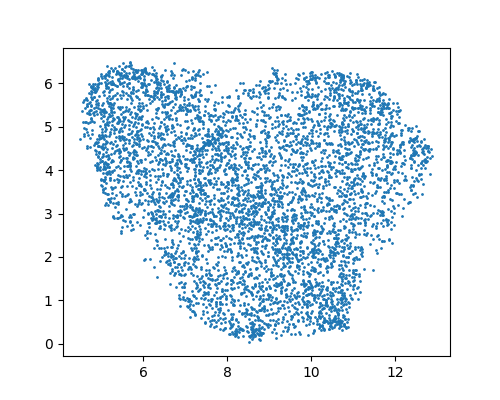

In [20]:
plot_cond_embedding(standard_embedding, cond_idx, 0)

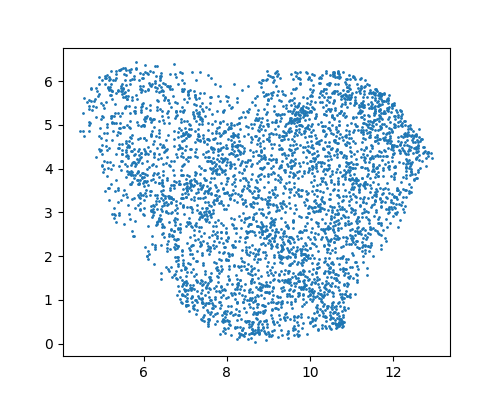

In [21]:
plot_cond_embedding(standard_embedding, cond_idx, 1)

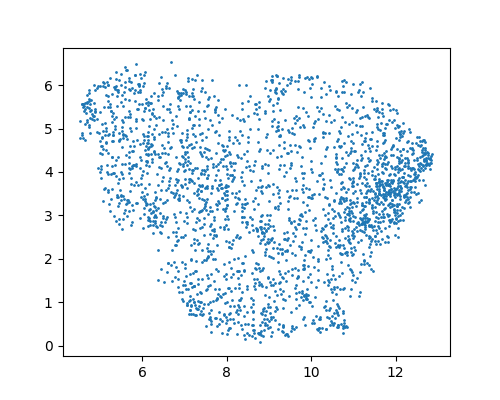

In [22]:
plot_cond_embedding(standard_embedding, cond_idx, 2)

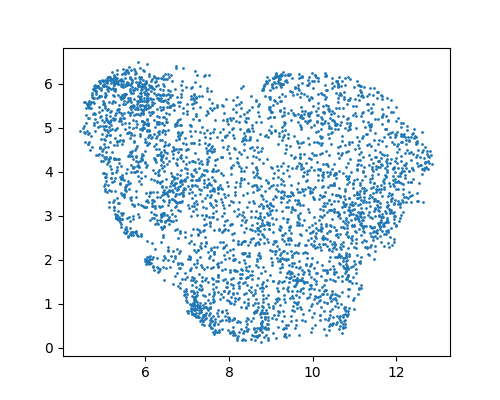

In [23]:
plot_cond_embedding(standard_embedding, cond_idx, 3)